In [1]:
# 先导入torch
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

# 然后晒一下自己的显卡，美滋滋^ ^
if torch.cuda.is_available():
    print(torch.cuda.get_device_properties(0))

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3080', major=8, minor=6, total_memory=10239MB, multi_processor_count=68)


In [2]:
# 还是先从做数据集开始
# 读一下
# torchvision是提供了这个数据集的，而且帮忙分好了训练集和数据集
# 如果自己把数据下下来放到指定目录了就不需要download了
def load_data(batch_size):
    # 常规的CV操作一下数据
    trans = transforms.ToTensor()
    data_train = torchvision.datasets.MNIST(root="./data", train=True, transform=trans, download=True)
    data_test = torchvision.datasets.MNIST(root="../data", train=False, transform=trans, download=True)
    # 继续调用torch的库函数，自己写真的麻烦死，这个工作数得根据自己硬件的情况改
    # 然后这里返回的是迭代器，比自己写的循环好多了，虽然也就是个yield的事
    return (data.DataLoader(data_train, batch_size, shuffle=True,num_workers=4),
            data.DataLoader(data_test, batch_size, shuffle=False,num_workers=4))

下面图像的标签为： 8


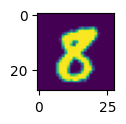

下面图像的标签为： 1


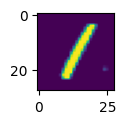

下面图像的标签为： 7


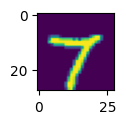

下面图像的标签为： 2


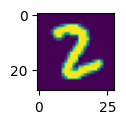

In [3]:
# 先看一下数据集，别弄成Fashion_Mnist了
show_size = 4
show_data, _ = load_data(show_size)
X, y = next(iter(show_data))

# 因为是黑白图去掉通道数就能显示
X = X.reshape(show_size, 28, 28)
for img, label in zip(X, y):
    print("下面图像的标签为：",label.item())
    plt.figure(figsize=(1, 1))
    plt.imshow(img)
    plt.show()
# 有些数据惨不忍睹啊，也不怪CNN不给力不能达到100%准确率

In [4]:
# 定义网络
# 原论文中最后一层是高斯连接，然后用MSE
# 但现在分类任务主要使用softmax
# 所以这里最后一层改为全连接层，并使用交叉熵作为损失函数
# 核的大小一般为3*3或者5*5，激活函数先选用sigmoid
# 计算卷积层输入输出矩阵大小的计算式
# M = (N+2*padding-kerner_size)/stride + 1向下取整
# 当满足如下关系时，矩阵大小不变
# padding = ((N-1)*stride-N+kernel_size)/2
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    # 先选用平均池化层，论文中称其为subsampling layeer
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    # 将矩阵展为一维向量，然后需要计算一下第一个线性层的输入
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

# 使用xavier初始化权重
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

In [5]:
# 定义批量大小获得数据集
batch_size = 256
train_iter, test_iter = load_data(batch_size)

In [6]:
# 因为是DL这边的所以就不用Tensorboard了
# 借用一下李沐老师d2l中的绘图库和计数库
# 手写一个计算测试集准确率的函数
def test(net, test_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    # 同样要阻挡梯度的传播
    with torch.no_grad():
        for X, y in test_iter:
            X = X.to(device)
            y = y.to(device)
            # 后者为数组中元素的个数
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train(net, train_iter, test_iter, num_epochs, lr, device):
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    # 这个交叉熵不是简单的交叉熵，而是经过softmax之后的交叉熵
    loss = nn.CrossEntropyLoss()
    # 绘图库
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],legend=['train loss', 'train acc', 'test acc'])
    # 开始训练
    num_batches = len(train_iter)
    for epoch in range(num_epochs):
        # 用于计数的
        metric = d2l.Accumulator(3)
        # 计算梯度以及dropout（这里没有用到）
        net.train()
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            # 存数据，阻断梯度传播，相当于用detach
            with torch.no_grad():
                # 分别是训练损失，训练的准确率，样本数
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            # 定期画图
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,(train_l, train_acc, None))
        # 计算这个epoch下，测试集上的准确率
        test_acc = test(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, 'f'test acc {test_acc:.3f}')

loss 0.208, train acc 0.936, test acc 0.945


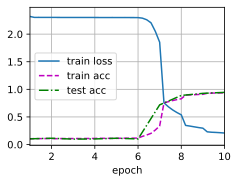

In [7]:
lr, num_epochs = 0.9, 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train(net, train_iter, test_iter, num_epochs, lr, device)

loss 0.031, train acc 0.990, test acc 0.986


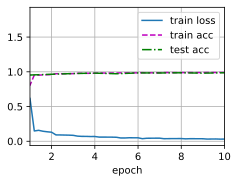

In [8]:
# 修改一下各个地方再试试
# 使用tanh和relu做激活函数
net1 = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
    # 先选用平均池化层，论文中称其为subsampling layeer
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # 将矩阵展为一维向量，然后需要计算一下第一个线性层的输入
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 10))

# 使用xavier初始化权重
net1.apply(init_weights)
train(net1, train_iter, test_iter, 10, 0.1, device)

loss 0.059, train acc 0.982, test acc 0.981


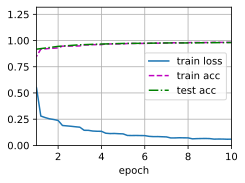

In [9]:
net2 = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Tanh(),
    # 先选用平均池化层，论文中称其为subsampling layeer
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Tanh(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    # 将矩阵展为一维向量，然后需要计算一下第一个线性层的输入
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Tanh(),
    nn.Linear(120, 84), nn.Tanh(),
    nn.Linear(84, 10))

# 使用xavier初始化权重
net2.apply(init_weights)
train(net2, train_iter, test_iter, 10, 0.1, device)

loss 0.462, train acc 0.865, test acc 0.870


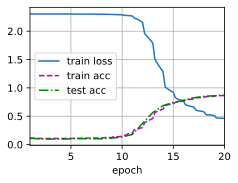

In [10]:
# 对于第一个网络更换学习率
net3 = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    # 先选用平均池化层，论文中称其为subsampling layeer
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    # 将矩阵展为一维向量，然后需要计算一下第一个线性层的输入
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

net3.apply(init_weights)
# 不能使用上面的net，因为已经训练好了
train(net3, train_iter, test_iter, 20, 0.1, device)